## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B test run by an e-commerce website to understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

Lets import libraries.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Reading the `ab_data.csv` data. Store it in `df`.  

Reading in the dataset and take a look at the top few rows here:

In [4]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Finding the number of rows in the dataset.

In [5]:
row_count = df.shape[0]
row_count

294478

Finding the number of unique users in the dataset.

In [6]:
df['user_id'].nunique()

290584

Finding the proportion of users converted.

In [7]:
df['converted'].value_counts()

0    259241
1     35237
Name: converted, dtype: int64

In [88]:
35237/df['user_id'].nunique()

0.12126269856564711

Finding number of times the `new_page` and `treatment` don't match.

In [8]:
df[((df['group'] == 'treatment') & (df['landing_page'] != 'new_page'))].count() + df[((df['group'] == 'control') & (df['landing_page'] != 'old_page'))].count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [9]:
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [10]:
treatment_newpage_mismatch = 1928+1965
treatment_newpage_mismatch

3893

Checking if any of the rows have missing values?

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

Storing new dataframe in **df2**.

In [12]:
mismtach_names1 = df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].index
mismtach_names2 = df[(df['group'] == 'control') & (df['landing_page'] != 'old_page')].index
df2 = df.drop(mismtach_names1)
df2 = df2.drop(mismtach_names2)

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** 

How many unique **user_id**s are in **df2**?

In [14]:
df2['user_id'].count()

290585

There is one **user_id** repeated in **df2**.  What is it?

In [15]:
repeated_userid = df2[df2['user_id'].duplicated()]
repeated_userid.values

array([[773192, '2017-01-14 02:55:59.590927', 'treatment', 'new_page', 0]],
      dtype=object)

Setermining the row information for the repeat **user_id**? 

In [16]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing **one** of the rows with a duplicate **user_id**, but keeping dataframe as **df2**.

In [17]:
df2 = df2.drop(1899)
df2.shape[0]

290584

`4.` Further analysis using **df2**

Determining the probability of an individual converting regardless of the page they receive?

In [18]:
(df2['converted']==1).mean()

0.11959708724499628

Given that an individual was in the `control` group, determine the probability they converted?

In [19]:
control_converted = df2.query('group =="control"')['converted'].mean()
control_converted

0.1203863045004612

Given that an individual was in the `treatment` group, determine the probability they converted?

In [20]:
treatment_converted = df2.query('group =="treatment"')['converted'].mean()
treatment_converted

0.11880806551510564

Determining the probability that an individual received the new page

In [21]:
newpage_prob = (df2['landing_page']=="new_page").mean()
newpage_prob

0.5000619442226688

Based on the results, it is seen that only 11.2% people converted into the program. 
The chance of conversion in control group and treatment group is almost the same i.e., around 12% and 11.8%.
So, there is not enough evidence to conclude that the new page is leading to higher number of conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, a hypothesis test could be run continuously as each observation is observed.  

However, then the hard question is whether to stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long to run inorder to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider that to make the decision just based on all the data provided.  If it is assumed that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses be?  Hypothesis is stated in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H$_0$ : P$_{old}$ $\ge$ P$_{new}$ <br>
H$_1$ : P$_{old}$ < P$_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Using the cells to provide the necessary parts of this simulation.  <br><br>

Determining the **conversion rate** for $p_{new}$ under the null

In [22]:
P_new = df2['converted'].mean()
P_new

0.11959708724499628

Determining the **conversion rate** for $p_{old}$ under the null <br>

In [23]:
P_old = df2['converted'].mean()
P_old

0.11959708724499628

Determining $n_{new}$, the number of individuals in the treatment group

In [24]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

Determining $n_{old}$, the number of individuals in the control group

In [25]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = df2.query('group == "treatment"')
new_null_vals = new_page_converted.query('converted == 1')['user_id'].nunique()/new_page_converted.query('converted == 0')['user_id'].nunique()
new_null_vals

0.13482654670977617

Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = df2.query('group == "control"')
old_null_vals = old_page_converted.query('converted == 1')['user_id'].nunique()/old_page_converted.query('converted == 0')['user_id'].nunique()
old_null_vals

0.13686269906483547

Finding $p_{new}$ - $p_{old}$ for simulated values from 2 previous values

In [28]:
obs_diff = new_null_vals - old_null_vals
obs_diff

-0.002036152355059301

Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = []
size = df2.shape[0]
for _ in range(10000):
    sample_df = df2.sample(size,replace=True)
    control_df = sample_df.query('group == "control"')
    treatment_df = sample_df.query('group == "treatment"')
    control_mean = control_df.query('converted == 1')['user_id'].nunique()/control_df.query('converted == 0')['user_id'].nunique()
    treatment_mean = treatment_df.query('converted == 1')['user_id'].nunique()/treatment_df.query('converted == 0')['user_id'].nunique()
    p_diffs.append(treatment_mean - control_mean)

Plot a histogram of the **p_diffs**. 

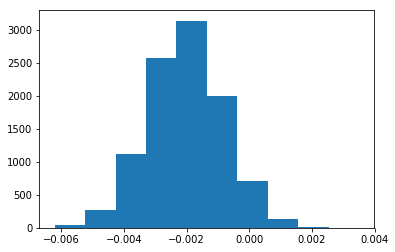

In [30]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
(p_diffs > obs_diff).mean()

0.5009

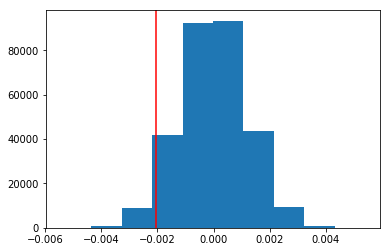

In [32]:
null_vals = np.random.normal(0,p_diffs.std(),size)
plt.hist(null_vals);
plt.axvline(obs_diff,color='r');

In [33]:
(null_vals > obs_diff).mean()

0.9563086749442502

0.957 is called as the p-value in scientific studies. Based on the result, it can be said that the p-value > .05 (Type 1 error rate) and hence we fail to reject the Null Hypothesis which states that old page is better than the new page.
Also, the observed diference falls within the plot which indicates that the result follows the Null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Below calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')
convert_new = df2.query('group == "treatment"')
n_old = convert_old.shape[0]
n_new = convert_new.shape[0]

C:\Users\thathrav\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [35]:
success_count = df2.query('converted == 1')['user_id'].nunique()
success_count

34753

Now use `stats.proportions_ztest` to compute test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [36]:
stats,pval = sm.stats.proportions_ztest(success_count,df2.shape[0],.05)
stats,pval

(115.61811279026708, 0.0)

What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?

Based on the result, it is seen that statistics is high and the p-value is 0, which indicates that it is statistically significant to move to the new page inorder to get more conversions.
This result does not agree with the finding s of parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, it will be seen that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should be performed in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives. However, first it is needed to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns ., then fit the model using the two columns  to predict whether or not an individual converts. 

In [38]:
lm = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


** Summary **

In [39]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-16 18:11 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

The p-value associated with ab_page is 0.1899. This differs from the p-value found in Part 2, since Logistic regression predicts the log odds and not the response.

Other factors that might influence whether an individual will convert or not is the time duration. It is shown below that the time range for which the prediction is based on is very small i.e., less than a month.
It would be helpful to monitor individual behavior over a longer range of period, which would give us more idea based on consistent usage of individuals.

In [40]:
(df2['timestamp'].min(),df2['timestamp'].max())

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset. 


In [42]:
country_df = pd.read_csv('countries.csv')
country_df['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [43]:
df2 = df2.join(country_df.set_index('user_id'),on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [44]:
dummy_country = pd.get_dummies(df2['country'])
df_new = df2.join(dummy_country)
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [45]:
lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','UK']])
res = lm.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-16 18:12 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

It is seen that p-value for the countries as well as ab_page is higher than .05. Hence it does not seem to be statistically significant to get conversion from new page.

Though the individual factors of country and page on conversion have been looked into, next look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.

In [46]:
df_new['ab_CA'] = df_new['ab_page']*df_new['CA']
df_new['ab_UK'] = df_new['ab_page']*df_new['UK']
df_new['ab_US'] = df_new['ab_page']*df_new['US']
lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','UK','ab_CA','ab_UK','ab_US']])
res = lm.fit()
res.summary2()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                 Logit             No. Iterations:    6.0000     
Dependent Variable:    converted         Pseudo R-squared:  0.000      
Date:                  2021-01-16 18:12  AIC:               212782.6602
No. Observations:      290584            BIC:               212846.1381
Df Model:              5                 Log-Likelihood:    -1.0639e+05
Df Residuals:          290578            LL-Null:           -1.0639e+05
Converged:             1.0000            Scale:             1.0000     
-----------------------------------------------------------------------
           Coef.    Std.Err.      z     P>|z|     [0.025       0.975]  
-----------------------------------------------------------------------
intercept -1.9865      0.0096 -206.3440 0.0000      -2.0053     -1.9676
ab_page   -0.0193 173587.6119   -0.0000 1.0000 -340225.4867 340225.4481
CA        -0.0175      0.0377   -0.4652 0.6418      -0.0914      0.0563
UK        -0.0057      0.0188   -0.3057 0.7598      -0.0426      0.0311
ab_CA     -0.0482 173587.6119   -0.0000 1.0000 -340225.5156 340225.4192
ab_UK      0.0301 173587.6119    0.0000 1.0000 -340225.4373 340225.4975
ab_US     -0.0013 173587.6119   -0.0000 1.0000 -340225.4687 340225.4661
=======================================================================

"""

Based on the result, it is seen that the p-value is high for the higher order terms i.e., for the relationship between the pages and countries. So it does not have a significant value on indicating that based on country type the page conversion varies.

In [124]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0